<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter4/4_2_%E8%A1%8C%E5%88%97%E5%88%86%E8%A7%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install packages
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
#@title Import packages
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

True principal axes:
[[ 1.62434536]
 [-0.61175641]]

True sigma:
0.8


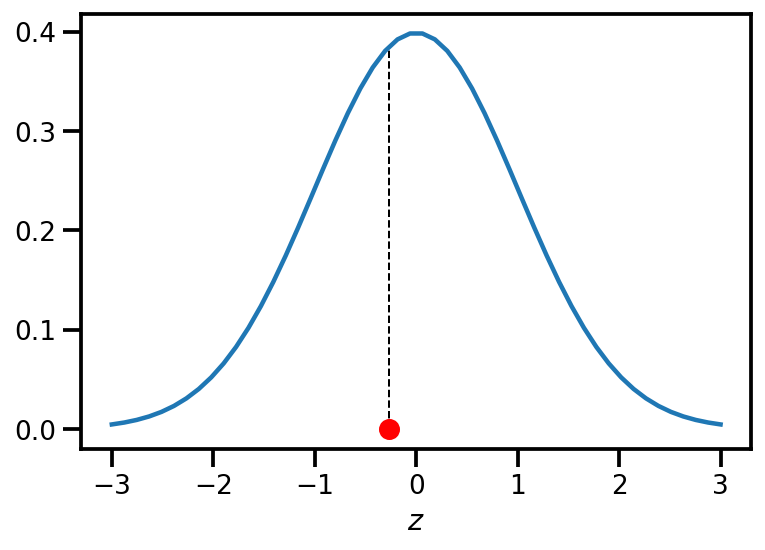

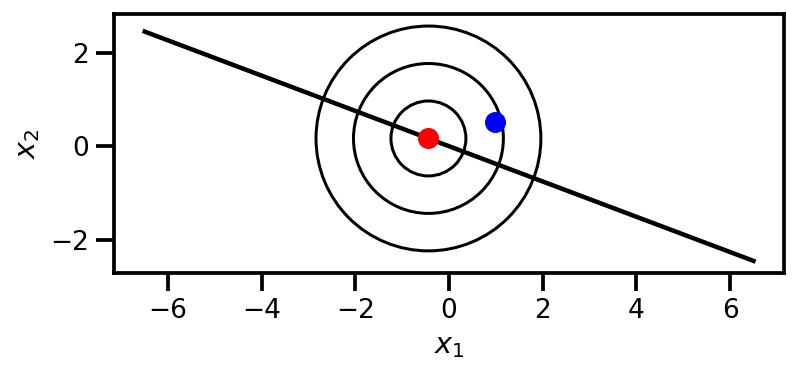

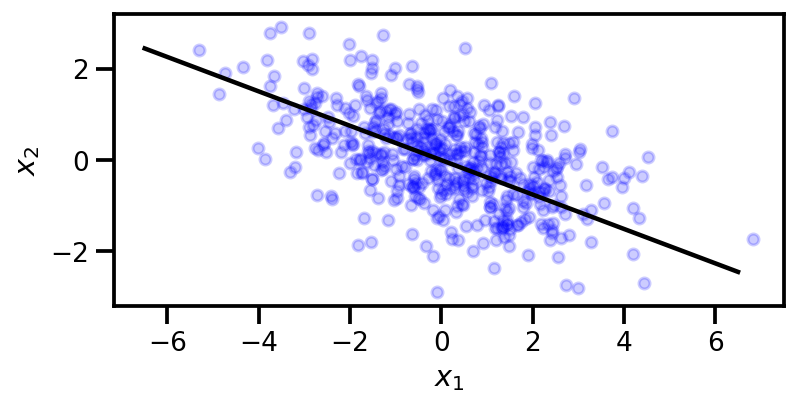

In [ ]:
#@title 確率的主成分分析のイメージ
from scipy import stats
from matplotlib import patches

### シミュレーションデータ生成
N = 500 # 観測データの数
D = 2   # 観測データの次元数
K = 1   # 潜在変数の次元数
sigma = 0.8

random_seed = 1

np.random.seed(random_seed)
x_train = np.zeros((D, N))
w = np.random.normal(0.0, 1.0, size=(D, K))
z = np.random.normal(0.0, 1.0, size=(K, N))
mean = np.dot(w, z)
for d in range(D):
    for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma)

print("True principal axes:")
print(w)
print()
print("True sigma:")
print(sigma)
###


zz = np.linspace(-3, 3)
norm = stats.norm()
z_s = norm.rvs() # 標準正規分布からのサンプルを１つ取得

# １次元の潜在変数をサンプリング
fig, ax = plt.subplots()
ax.plot(zz, norm.pdf(zz))
ax.vlines(x=z_s, ymin=0, ymax=norm.pdf(z_s), color='k', ls='--', lw=1)
# ax.plot([-3, 3], [0, 0], color='k')
ax.scatter(z_s, 0, color='r', zorder=3)
ax.set_xlabel('$z$')

# 線形変換
zz2 = np.linspace(-4, 4)
x_mean = w.dot(zz2[np.newaxis])
x_s = w.dot(z_s)

# 等方的な2次元正規分布から観測値をサンプリング
np.random.seed(3)
x_o = stats.norm(x_s, sigma).rvs()

fig, ax = plt.subplots()
ax.plot(x_mean[0], x_mean[1], color='k')
ax.scatter(x_s[0], x_s[1], color='r', zorder=3)
ax.scatter(x_o[0], x_o[1], color='b', zorder=3)
# 2次元正規分布のイメージ
c1 = patches.Circle(x_s.ravel(), sigma, fill=False, ec='k')
c2 = patches.Circle(x_s.ravel(), 2*sigma, fill=False, ec='k')
c3 = patches.Circle(x_s.ravel(), 3*sigma, fill=False, ec='k')
ax.add_patch(c1)
ax.add_patch(c2)
ax.add_patch(c3)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal')

# 観測データ
fig, ax = plt.subplots()
ax.plot(x_mean[0], x_mean[1], color='k')
ax.scatter(x_train[0, :], x_train[1, :], color='blue', s=30, alpha=0.2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal')

In [ ]:
#@title 人工データ生成用の関数
def build_toy_dataset(N, D, K, sigma=2.0, random_seed=1):
    np.random.seed(random_seed)
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 1.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    print()
    print("True sigma:")
    print(sigma)
    return x_train

True principal axes:
[[ 1.62434536]
 [-0.61175641]]

True sigma:
0.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


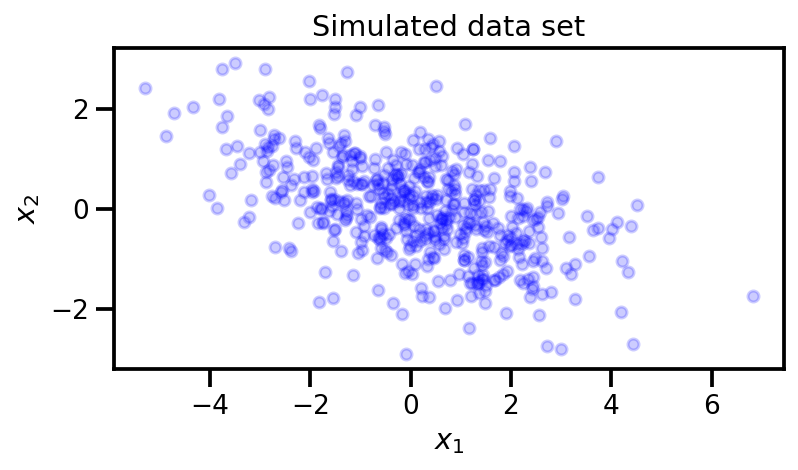

In [ ]:
N = 500 # 観測データの数
D = 2   # 観測データの次元数
K = 1   # 潜在変数の次元数
sigma = 0.8

x_train = build_toy_dataset(N, D, K, sigma)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', s=30, alpha=0.2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Simulated data set")
plt.axes().set_aspect(1.0)

In [ ]:
# 参考：通常の主成分分析
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(x_train.transpose())
pca.components_

array([[ 0.93872151, -0.34467656]])

In [ ]:
with pm.Model() as model:
    w = pm.Normal('w', mu=np.zeros([D, K]), sd=np.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=np.zeros([N, K]), sd=np.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=5)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*np.ones([D, N]), shape=[D, N], observed=x_train)  

In [ ]:
with model:
    trace = pm.sample(2000, chains=3, random_seed=42, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (3 chains in 1 job)
NUTS: [sigma, z, w]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


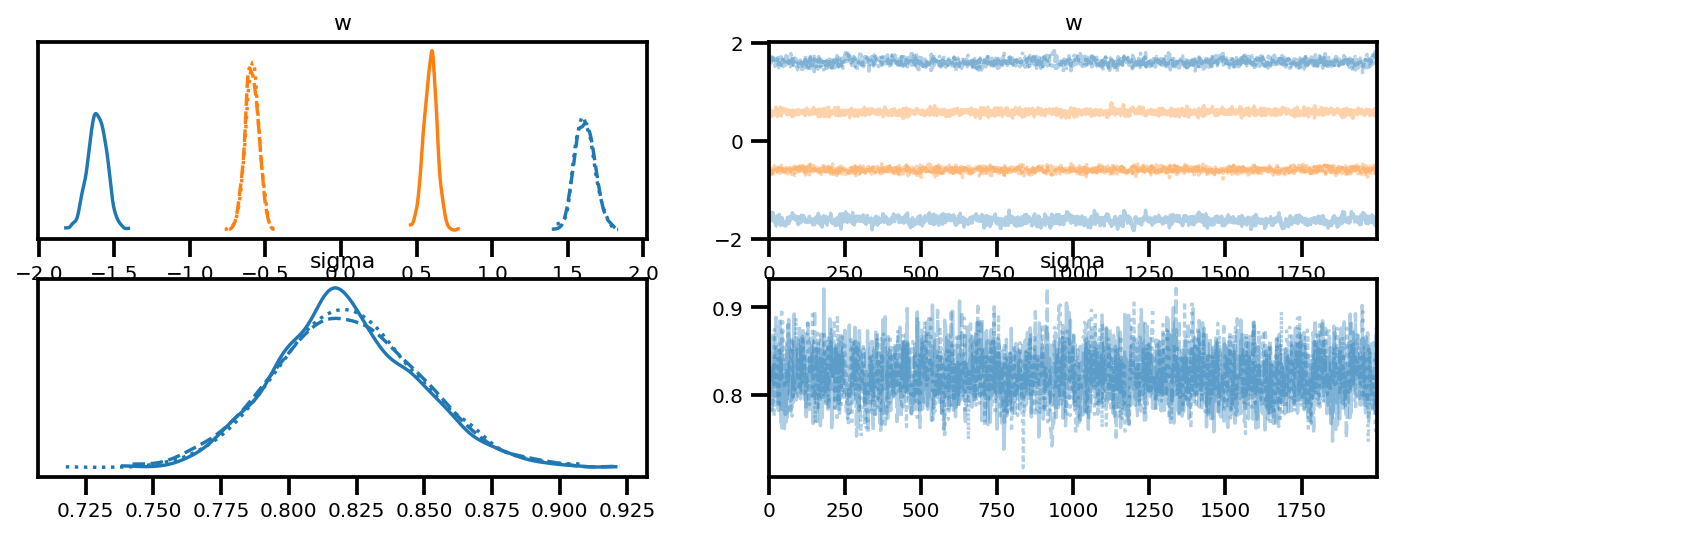

In [ ]:
axes = az.plot_trace(trace, var_names=['w', 'sigma'])
axes[0,0].figure.legend([0, 1, 2], 
                        title='chain',
                        loc='center left', 
                        bbox_to_anchor=(1.0, 0.5))

In [ ]:
# 1番目のchainのみ用いて要約統計量を算出
az.summary(trace.sel(chain=[0]), var_names=['w', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
"w[0, 0]",-1.614,0.063,-1.729,-1.495
"w[1, 0]",0.590,0.044,0.508,0.674
sigma,0.821,0.026,0.773,0.869


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


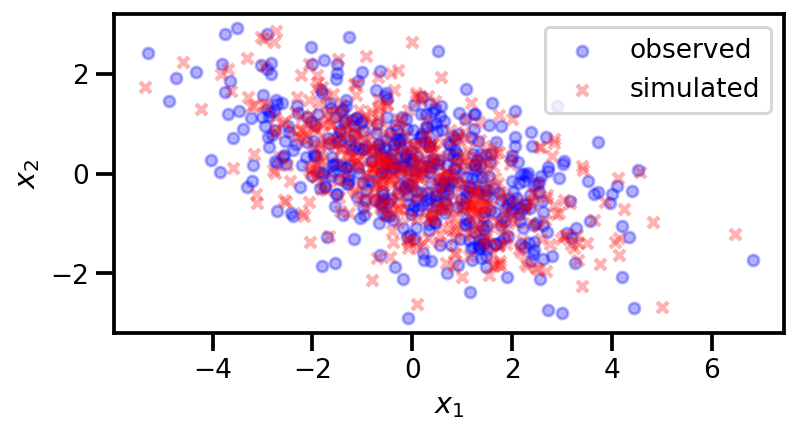

In [ ]:
with model:
    x_post = pm.sample_posterior_predictive(trace, 1, random_seed=42)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', s=30, alpha=0.3, label='observed')
plt.scatter(x_post['x'][0, 0, :], x_post['x'][0, 1, :], color='red', marker='x', s=30, alpha=0.3, label='simulated')
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axes().set_aspect(1.0)

# 確率的行列分解によるレコメンデーション

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(42)

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
#@title TFP用のutility関数
def init_random(shape, n_chains=1, r=2):
    """
    StanのようにUniform(-2, 2)で初期化する
    """
    if n_chains == 1:
        return tf.random.uniform(shape, -r, r)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

In [ ]:
data = pd.read_csv(
    'http://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
    usecols=[0, 1, 2], 
    names=["user_id", "item_id", "rating"], 
    sep="\t"
)

display(data.head())

# 行列形式に変換
dense_data = data.pivot(index='user_id', columns='item_id', values='rating').values

num_users = dense_data.shape[0]
num_items = dense_data.shape[1]
sparsity = np.isnan(dense_data).mean()
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity:.2f}")

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Users: 943
Movies: 1682
Sparsity: 0.94


count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

(0.0, 1682.0)

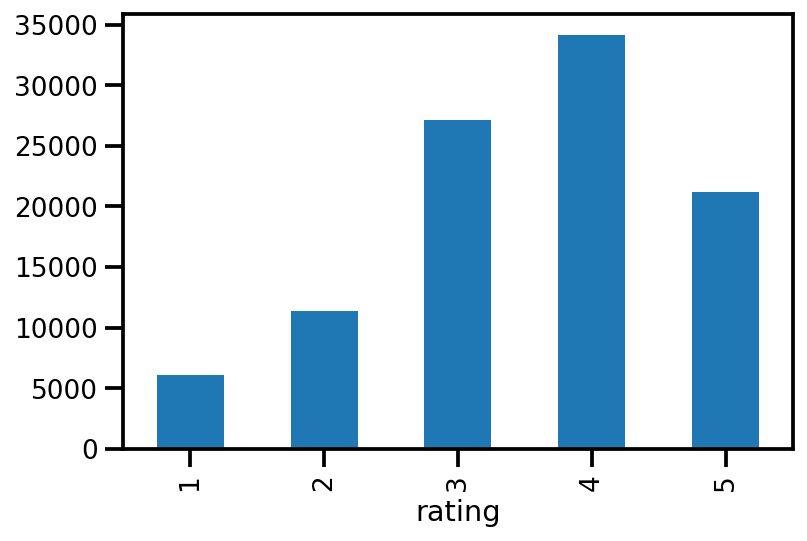

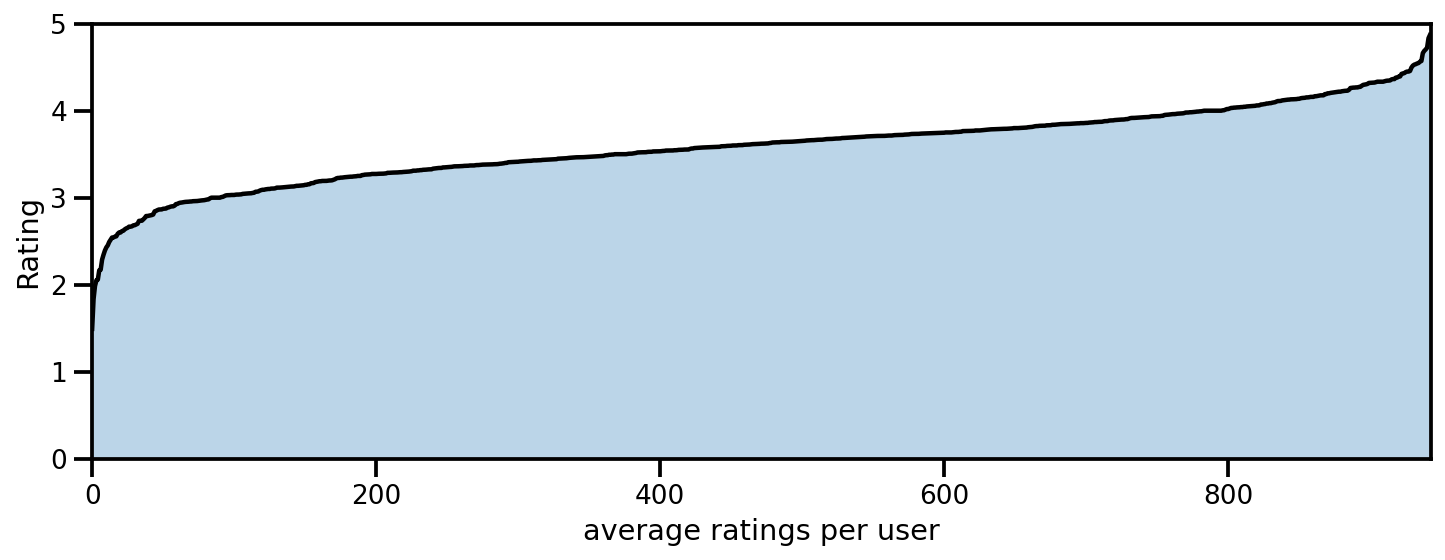

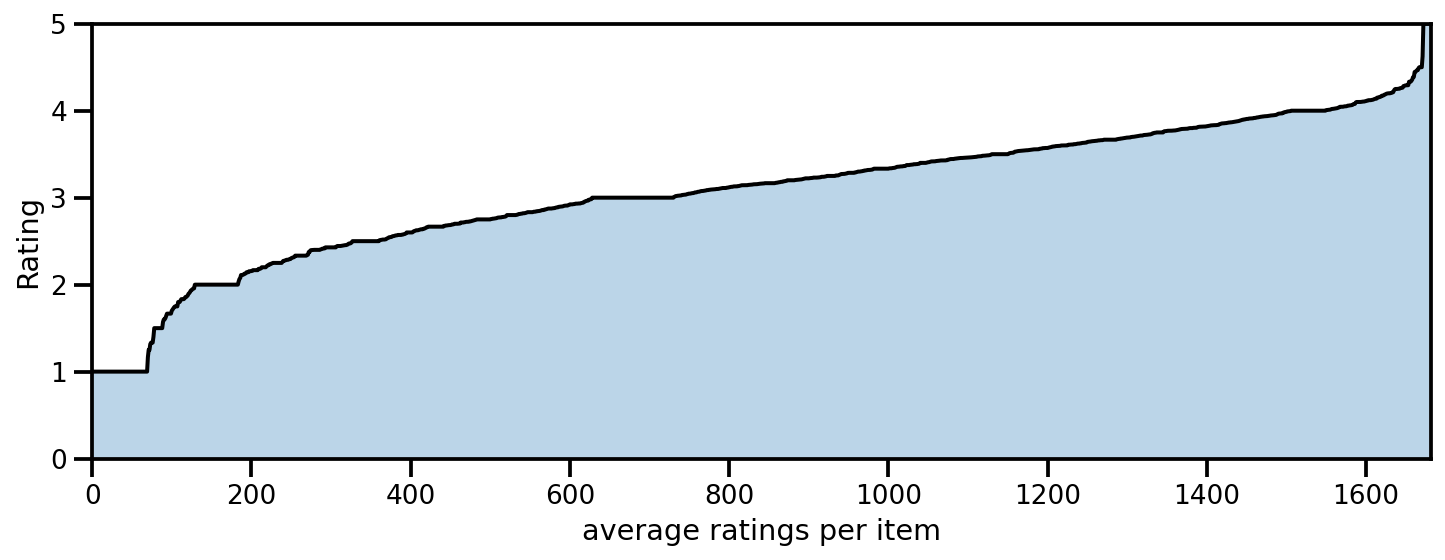

In [ ]:
#@title データ可視化
data.groupby("rating").size().plot(kind="bar")
display(data.rating.describe())

user_means = data.groupby("user_id")['rating'].mean().sort_values()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_ylabel("Rating")
ax.set_xlabel("average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means))


item_means = data.groupby("item_id")['rating'].mean().sort_values()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(len(item_means)), item_means.values, "k-", lw=2)

ax.fill_between(np.arange(len(item_means)), item_means.values, alpha=0.3)
ax.set_ylabel("Rating")
ax.set_xlabel("average ratings per item")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(item_means))

In [ ]:
#@title データ分割、ベースライン、性能評価用の関数(hide)
def split_train_test(data, test_ratio=0.1, random_seed=1):
    """学習データとテストデータに分割"""
    np.random.seed(random_seed)
    
    # 学習・テストデータを格納する変数を用意
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # 学習データの一部をランダムに抽出し、テストデータとする
    to_sample = np.where(~np.isnan(train))
    # 欠損でない評価値のインデックス（行番号・列番号のタプル）のリスト
    idx_pairs = list(zip(to_sample[0], to_sample[1]))   

    test_size = int(len(idx_pairs) * test_ratio)
    train_size = len(idx_pairs) - test_size

    indices = np.arange(len(idx_pairs))
    # テストデータとする評価値のインデックスの番号
    sample = np.random.choice(indices, replace=False, size=test_size)

    # 学習データからテストデータに移し替える
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]
        train[idx_pair] = np.nan

    # 念のため分割後のデータを確認
    assert(train_size == (~np.isnan(train)).sum())
    assert(test_size == (~np.isnan(test)).sum())

    return train, test


def baseline_prediction(train_data):
    """ユーザーごとの平均、映画ごとの平均、全体の平均の3つの平均の平均値を予測値とするベースライン"""
    nan_mask = np.isnan(train_data)
    masked_train = np.ma.masked_array(train_data, nan_mask)
    global_mean = masked_train.mean()
    user_means = masked_train.mean(axis=1)
    item_means = masked_train.mean(axis=0)
    
    pred = train_data.copy()
    n, m = train_data.shape
    for i in range(n):
        for j in range(m):
            if np.ma.isMA(item_means[j]):
                pred[i, j] = np.mean(
                    (global_mean, user_means[i]))
            else:
                pred[i, j] = np.mean(
                    (global_mean, user_means[i], item_means[j]))
    return pred


def rmse(test_data, predicted):
    """テストデータにおけるRMSEを算出。欠損値は無視する。"""
    I = ~np.isnan(test_data)
    N = I.sum()
    sqerror = np.abs(test_data - predicted) ** 2
    mse = sqerror[I].sum() / N
    return np.sqrt(mse)

In [ ]:
train, test = split_train_test(dense_data)

baseline = baseline_prediction(train)
baseline_score = rmse(test, baseline)
print(f'RMSE of baseline: {baseline_score:.2f}')

RMSE of baseline: 1.02


### PyMC3による実装
かなり時間がかかるため、TFPで実装する。


In [ ]:
# dim = 5
# alpha = 2.0
# std = np.sqrt(1.0 / alpha)
# bounds = (1, 5)

# n, m = train.shape
# data_fill = train.copy()

# # Perform mean value imputation
# nan_mask = np.isnan(data_fill)
# data_fill[nan_mask] = data_fill[~nan_mask].mean()

# # Low precision reflects uncertainty; prevents overfitting.
# # Set to the mean variance across users and items.
# alpha_u = 1 / data_fill.var(axis=1).mean()
# alpha_v = 1 / data_fill.var(axis=0).mean()


# with pm.Model() as pmf:
#     U = pm.MvNormal(
#         "U",
#         mu=0,
#         tau=alpha_u * np.eye(dim),
#         shape=(n, dim),
#         testval=np.random.randn(n, dim) * std,
#     )
#     V = pm.MvNormal(
#         "V",
#         mu=0,
#         tau=alpha_v * np.eye(dim),
#         shape=(m, dim),
#         testval=np.random.randn(m, dim) * std,
#     )
#     R = pm.Normal(
#         "R", mu=(U @ V.T)[~nan_mask], tau=alpha, observed=train[~nan_mask]
#     )

# %%time
# with pmf:
    # trace = pm.sampling_jax.sample_numpyro_nuts(500, chains=1)
    # trace = pm.sample(500, chains=1)

## CPU times: user 2h 1min 22s, sys: 55.2 s, total: 2h 2min 17s
# %%time
# with pmf:
#     trace2 = pm.sampling_jax.sample_tfp_nuts(500, chains=1)

### TFPによる実装


In [ ]:
dtype = np.float32

latent_dim = 5 # 潜在変数の次元
bounds = (1, 5) # レーティングの取りうる範囲
n_user, n_item = train.shape

# 学習データにおける、欠損値のインデックス
nan_mask = np.isnan(train) 

# U, Vの標準偏差は、それぞれユーザー、アイテムの標準偏差の平均値に固定
train_fill = train.copy()
train_fill[nan_mask] = train[~nan_mask].mean()
stddv_U = train_fill.std(axis=1).mean().astype(dtype)
stddv_V = train_fill.std(axis=0).mean().astype(dtype)

# Rの標準偏差は固定値に設定
alpha = 2.0
stddv_datapoints = np.sqrt(1/alpha).astype(dtype)


def pmf():
    Root = tfd.JointDistributionCoroutine.Root
    # user
    U = yield Root(tfd.Independent(
      tfd.Normal(loc=tf.zeros([n_user, latent_dim]),
                 scale=stddv_U * tf.ones([n_user, latent_dim]),
                 name="U"), reinterpreted_batch_ndims=2))
    # item
    V = yield Root(tfd.Independent(
      tfd.Normal(loc=tf.zeros([latent_dim, n_item]),
                 scale=stddv_V * tf.ones([latent_dim, n_item]),
                 name="V"), reinterpreted_batch_ndims=2))
    
    R = yield tfd.Independent(
        tfd.Normal(loc=tf.matmul(U, V)[~nan_mask],
                   scale=stddv_datapoints,
                   name="R"), reinterpreted_batch_ndims=1)


model = tfd.JointDistributionCoroutine(pmf)
target_log_prob_fn = lambda U, V: model.log_prob(U, V, train[~nan_mask])

Colaboratoryで実行する場合、推論に10分弱かかります。

In [ ]:
%%time
num_results = 1000
num_burnin_steps = 1000

@tf.function
def do_sampling():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      num_steps_between_results=5, # thinning
      current_state=[
          init_random([n_user, latent_dim]),
          init_random([latent_dim, n_item])
      ],
      kernel=tfp.mcmc.SimpleStepSizeAdaptation(
          ｔfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=target_log_prob_fn,
              step_size=0.1,
          num_leapfrog_steps=10),
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

states, kernel_results = do_sampling()

Cause: Unable to locate the source code of <function do_sampling at 0x7faeeea84a70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function do_sampling at 0x7faeeea84a70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 10min 27s, sys: 28.4 s, total: 10min 55s
Wall time: 7min 4s


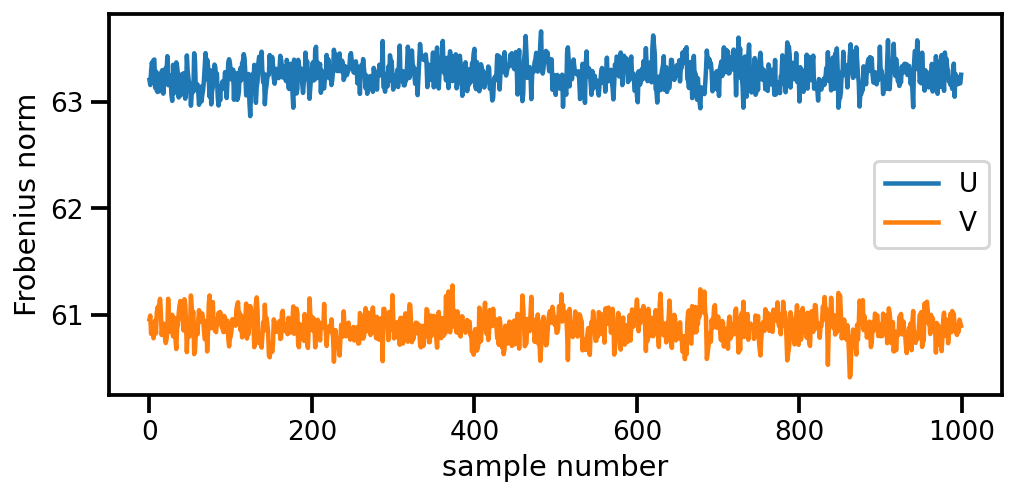

In [ ]:
U_norm = np.linalg.norm(states[0], axis=(1,2))
V_norm = np.linalg.norm(states[1], axis=(1,2))

plt.figure(figsize=(8, 3.5))
plt.plot(U_norm, label='U')
plt.plot(V_norm, label='V')
plt.xlabel('sample number')
plt.ylabel('Frobenius norm')
plt.legend()

In [ ]:
#@title 性能評価用の関数
def predict(u, v, sd, bounds=(1, 5)):
    r = tf.matmul(u, v)
    # Rのサンプルを取得
    sample_r = tfd.Normal(loc=r, scale=sd).sample()
    # レーティングの上限・下限に収まるようにクリッピング
    sample_r = tf.clip_by_value(sample_r, *bounds)
    return sample_r

def running_rmse(states, train_data, test_data, burnin=0):
    from tqdm.notebook import tqdm

    states = [s[burnin:] for s in states]
    results = {'per-step-train': [], 'running-train': [],
              'per-step-test': [], 'running-test': []}
    r = np.zeros(train_data.shape)
    for i in tqdm(range(len(states[0]))):
        # U, VのサンプルからRのサンプルを取得
        sample_r = predict(states[0][i], states[1][i], stddv_datapoints).numpy()
        r += sample_r
        # 現時点までのサンプルの平均
        running_r = r / (i + 1)
        # RMSEの算出
        results['per-step-train'].append(rmse(train_data, sample_r))
        results['running-train'].append(rmse(train_data, running_r))
        results['per-step-test'].append(rmse(test_data, sample_r))
        results['running-test'].append(rmse(test_data, running_r))

    results = pd.DataFrame(results)
    return running_r, results

In [ ]:
pred, results = running_rmse(states, train, test)

test_rmse = results['running-test'].values[-1]
train_rmse = results['running-train'].values[-1]
print(f'train RMSE: {train_rmse:.3f}')
print(f'test RMSE: {test_rmse:.3f}')
print(f'test RMSE(baseline): {baseline_score:.3f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

train RMSE: 0.859
test RMSE: 0.944
test RMSE(baseline): 1.017


Text(0, 0.5, 'RMSE')

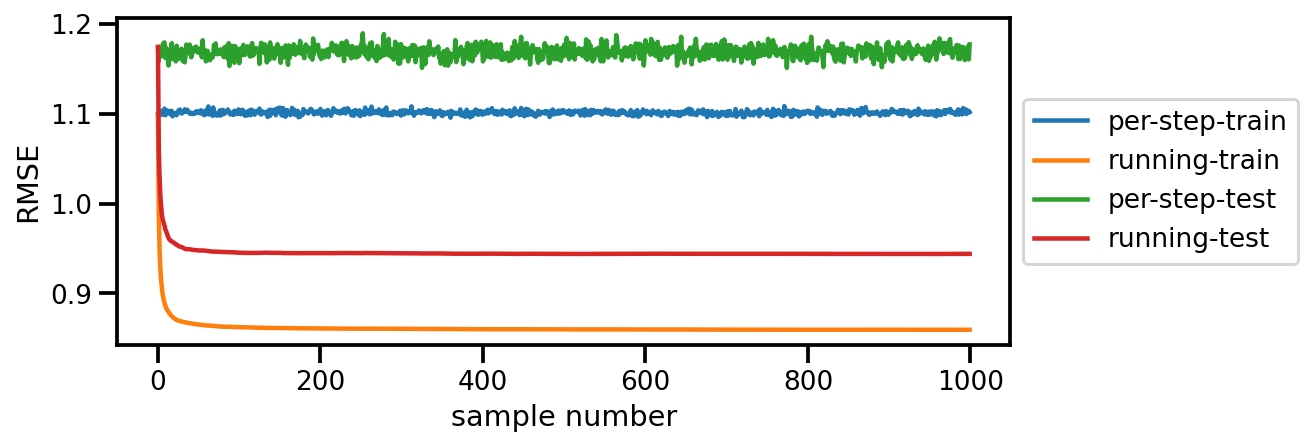

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
results.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
ax.set_xlabel('sample number')
ax.set_ylabel('RMSE')

In [ ]:
%load_ext watermark
%watermark --iversions

pandas                : 1.3.5
tensorflow_probability: 0.16.0
pymc3                 : 3.11.4
seaborn               : 0.11.2
scipy                 : 1.4.1
arviz                 : 0.12.1
matplotlib            : 3.2.2
tensorflow            : 2.8.0+zzzcolab20220506162203
IPython               : 5.5.0
numpy                 : 1.21.6

